# **나이브 베이즈 모델을 이용한 스팸메일 분류기**
Calssification

## **1 분류기 Classification**
1. **Binary Classification** (이진 분류기) : **True / False 조건을** 구분한다
1. **Multiclass Classification** (다변량 분류) : **다양한 클래스간의 조건을** 구분한다
1. **Multi-label Classification** (다중 클래스 레이블 분류) : 다중의 클래스간 **겹치는 조건에서** 구분을 한다

<img src="https://wikidocs.net/images/page/4291/logreg702.PNG" width=400>

## **2 텍스트 분류기 Classification**
1. **긍정/ 부정,  긍정/ 중립/ 부정** 분류기
1. **뉴스의 토픽** 분류기 (**class 간 중첩되어** 분류가 가능하다)
1. **Named Entity Recognition** (개체명 분류기) : ex) Naive Bayse, Support Vector Machine

## **3  Naive Bayse Classification 개념**
1. 확률 기반의 분류기
1. **Naive :** 예측을 위한 Token 들이 **Mutually Independent** (상호독립적)을 가정
1. **Bayse :** 관찰한 Token이 **클래스 전체 대비, 특정 클래스 속할 확률을 Bayse 기반** 으로 계산

> **Naive Bayse 메커니즘**

1. 스팸메일과, 정상메일로 구분된 데이터를 사용한다 [download](http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron1.tar.gz)
1. 단어 **Token을** 대상으로 **스팸여부를** 학습한다.
1. Data 추가시 잘못 예측한 결과에 대해 **Laplace Smoothing** 으로 보완한 값을 **Bayse 로 공식을** 수정한다

## **4   Naive Bayse 구현하기**
스펨메일 데이터 다운받기 [download](http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron1.tar.gz)
<br>
### **01 enron 메일데이터 살펴보기**
1. **Summary.txt** 파일에 저장된 내용 살펴보기
1. **정상메일 (3,672개)** 와 **스펨메일 (1,500)개로** 약 1:2의 비율로 구분이 된다

In [2]:
# 스팸메일 데이터 Summary
with open('./data/enron1/Summary.txt', 'r') as f:
    summary = f.read()
print(summary)

Legitimate
----------
- Owner: farmer-d
- Total number: 3672 emails
- Date of first email: 1999-12-10
- Date of last email: 2002-01-11
- Similars deletion: No
- Encoding: No


Spam
----
- Owner: GP
- Total number: 1500 emails
- Date of first email: 2003-12-18
- Date of last email: 2005-09-06
- Similars deletion: No
- Encoding: No

Spam:Legitimate rate = 1:3
Total number of emails (legitimate + spam): 5975



In [3]:
# ham 폴더에 저장된 메일내용 확인 (정상으로 분류된 메일)
file_path = './data/enron1/ham/0007.1999-12-14.farmer.ham.txt'
with open(file_path, 'r') as infile:
    ham_sample = infile.read()
print(ham_sample)

Subject: mcmullen gas for 11 / 99
jackie ,
since the inlet to 3 river plant is shut in on 10 / 19 / 99 ( the last day of
flow ) :
at what meter is the mcmullen gas being diverted to ?
at what meter is hpl buying the residue gas ? ( this is the gas from teco ,
vastar , vintage , tejones , and swift )
i still see active deals at meter 3405 in path manager for teco , vastar ,
vintage , tejones , and swift
i also see gas scheduled in pops at meter 3404 and 3405 .
please advice . we need to resolve this as soon as possible so settlement
can send out payments .
thanks


In [4]:
# spam 폴더에 저장된 메일내용 확인 (스팸으로 분류된 메일)
file_path = './data/enron1/spam/0058.2003-12-21.GP.spam.txt'
with open(file_path, 'r') as infile:
    spam_sample = infile.read()
print(spam_sample)

Subject: stacey automated system generating 8 k per week parallelogram
people are
getting rich using this system ! now it ' s your
turn !
we ' ve
cracked the code and will show you . . . .
this is the
only system that does everything for you , so you can make
money
. . . . . . . .
because your
success is . . . completely automated !
let me show
you how !
click
here
to opt out click here % random _ text



### **02 enron 메일 데이터 분류하기**
1. 스펨메일과 정상메일을 레이블을 사용하여 분류한다
1. 1 : 스펨메일,  0 : 정상메일
1. 분류된 데이터를 전처리 과정을 진행한다

In [5]:
import glob,os
# 정상매일은 0, 스펨매일은 1
emails, labels = [], []
for no, file_path in enumerate(['./data/enron1/ham/','./data/enron1/spam/']):
    for filename in glob.glob(os.path.join(file_path, '*.txt')):
        with open(filename, 'r', encoding = "ISO-8859-1") as infile:
            emails.append(infile.read())
            labels.append(no)

### **03 enron 메일 데이터 임베딩**
1. Chapter 2 에서 진행한 내용을 바탕으로 전처리 작업을 진행한다
1. **숫자와 구두점** 제거, **StopWords** 제거, **표제어 원형** 복원
1. 정제된 데이터로 **희소벡터 (Sparse Vector)** 로 임베딩 ex) (**row index, feacture/term index**)

In [6]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer
all_names  = set(names.words())
lemmatizer = WordNetLemmatizer()

# 표제어 복원작업
def clean_text(docs):
    cleaned    = [' '.join([lemmatizer.lemmatize(word.lower())
                        for word in doc.split()
                        if word.isalpha() and word not in all_names])   
              for doc in docs]
    return cleaned

# 사용자 함수를 활용하여 전처리 작업을 진행한다
cleaned_emails = clean_text(emails)
cleaned_emails[0]

'fw customer list this one includes more financial counterparties non eol original message from winfree o neal d sent wednesday december am to martin thomas a subject customer list tom attached are eol customer between july and nov broken out by physical and financial the only physical customer i remember non eol are imperial sugar and texas energy i m also checking this list against other non eol deal eric or joe might have done but for now take a look at this o'

In [7]:
%%time
# 출현빈도가 높은 상위 500개의 Token을 대상으로 임베딩 한다
# 희소벡터(Sparse Vector)로 변환 : (row index, feacture/term index)
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words="english", max_features=500)
term_docs      = cv.fit_transform(cleaned_emails)
print("모델의 Type: {}\n임베딩의 크기: {}\n0번문장 내용보기: \n{}".format(
    type(term_docs),
    term_docs.shape, # 5,172개 문장을 500개 단어로 생성
    term_docs [0]))  # 0번 문장의 단어 Vector 목록을 출력

모델의 Type: <class 'scipy.sparse.csr.csr_matrix'>
임베딩의 크기: (5172, 500)
0번문장 내용보기: 
  (0, 248)	1
  (0, 102)	1
  (0, 125)	1
  (0, 435)	1
  (0, 224)	1
  (0, 30)	1
  (0, 447)	1
  (0, 417)	1
  (0, 104)	1
  (0, 482)	1
  (0, 390)	1
  (0, 265)	1
  (0, 307)	1
  (0, 147)	2
  (0, 241)	3
  (0, 94)	4
  (0, 162)	1
CPU times: user 611 ms, sys: 7.26 ms, total: 618 ms
Wall time: 617 ms


In [8]:
# cv 모델로 인덱스별 단어 Token 내용보기
# feature_mapping = cv.vocabulary_       # dict 로 내용출력 (key:value)

print(cv.get_feature_names()[:7])
feature_names   = cv.get_feature_names() # List 로 내용출력 (인덱스별 value)
for indx in [0, 162, 481, 357, 125]:
    print(indx, ":", feature_names[indx])

['able', 'access', 'account', 'accounting', 'act', 'action', 'activity']
0 : able
162 : fw
481 : website
357 : read
125 : energy


### **04-1 Naive Bayse 학습을 위한 준비작업**
모델의 학습을 위한 준비작업으로 데이터를 그룹화 한다

In [9]:
# 레이블을 기준으로 데이터를 그룹화 한다
# defaultdict : 스팸여부 0,1 Tag 로 Token Index List 생성
def get_label_index(labels):
    from collections import defaultdict
    label_index = defaultdict(list)
    for index, label in enumerate(labels):
        label_index[label].append(index)
    return label_index

# 0 ~ 3600 : 정상메일[0], 3600 ~ 나머지 : 스팸메일[1]
label_index = get_label_index(labels)
print(label_index.keys())
label_index[1][:10]

dict_keys([0, 1])


[3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681]

### **04-2 Naive Bayse 위한 사전확률/ 우도값 계산**
**사전확률 및 우도값을** 계산하는 함수를 정의한다

In [10]:
# 학습 샘플을 활용하여 사전 확률을 계산 
def get_prior(label_index):
    """ Compute prior based on training samples
    Args:    label_index (grouped sample indices by class)
    Returns: { 단어 key : corresponding prior } """
    prior = {label: len(index) for label, index in label_index.items()}
    total_count = sum(prior.values())
    for label in prior:
        prior[label] /= float(total_count)
    return prior

# 위의 인덱스 데이터를 활용하여 사전확률을 계산한다
prior = get_prior(label_index)
prior

{0: 0.7099767981438515, 1: 0.2900232018561485}

In [11]:
# 확률적 유사가능도(최대 가능도 추정)를 계산: 빈도상위 500개의 단어로 조건부 확률 p(feature|spam)을 계산
import numpy as np
def get_likelihood(term_document_matrix, label_index, smoothing=0):
    """ 훈련 데이터로 우도값 측정
    Args:    term_document_matrix, label_index, smoothing        
    Returns: { 단어 key, 동시확률 P(feature|class) }
    """
    likelihood = {}
    for label, index in label_index.items():
        likelihood[label] = term_document_matrix[index, :].sum(axis=0) + smoothing
        likelihood[label] = np.asarray(likelihood[label])[0]
        total_count       = likelihood[label].sum()
        likelihood[label] = likelihood[label] / float(total_count)
    return likelihood

smoothing  = 1           # 라플라스 스무딩
likelihood = get_likelihood(term_docs, label_index, smoothing)
print("우도값 shape : {}\n단어 내용보기 : {}\n우도값 array :\n{}".format(
    likelihood[0].shape, # 0번 레이블일 때 단어별 우도값 계산
    feature_names[:5],   # 인덱스별 단어 확인
    likelihood[0][:20])) # 0번 레이블의 단어별 우도값 샘플 [:20]

우도값 shape : (500,)
단어 내용보기 : ['able', 'access', 'account', 'accounting', 'act']
우도값 array :
[1.08580656e-03 9.57737068e-04 8.79781725e-04 8.46372292e-04
 1.00228298e-04 2.39434267e-04 1.97115652e-03 1.34194554e-03
 1.84308703e-03 8.35235815e-04 1.08023832e-03 1.03012417e-03
 1.67047163e-05 1.50342447e-04 7.62848711e-04 8.40804054e-04
 8.12962860e-04 2.22172727e-03 1.99342948e-03 5.01141489e-05]


### **04-3 자연 Log 를 활용한 예측함수 구현하기**
- 앞에서 측정한 **사전확률과 및 우도값을** 활용하여 예측함수를 정의 합니다
- 단어들의 확률을 합치기 위해, **Log()** 로 변환 후 **경우의 수를 모두 합칩니다**

In [12]:
# OverFlow가 발생 가능하므로, 데이터를 Log() 자연로그로 변환 후 덧셈 계산,
# 계산이 끝난 뒤, 로그의 역함수 (exp()) 를 활용하여 실수로 변환한다
def get_posterior(term_document_matrix, prior, likelihood):
    """ 사전확률과 유사가능도를 바탕으로 샘플 데이터의 사후확률을 계산
    Args:
        term_document_matrix (sparse matrix)
        prior      { 단어 Key : 사전확률 }
        likelihood { 단어 Key : 조건부 확률 }
    Returns:       { 단어 Key : 관련 사후 확률값 }
    """
    # 확률의 연산시 log() 로 변환한 후 합친다
    num_docs, posteriors = term_document_matrix.shape[0], []
    for i in range(num_docs):
        # 사후확률 : 사전확률 X 유사가능도(최대 가능도 추정량)
        posterior = {key: np.log(prior_label) for key, prior_label in prior.items()}
        for label, likelihood_label in likelihood.items():
            term_document_vector = term_document_matrix.getrow(i)
            counts  = term_document_vector.data
            indices = term_document_vector.indices
            for count, index in zip(counts, indices):
                posterior[label] += np.log(likelihood_label[index]) * count
        # exp(-1000):exp(-999) 는 분모가 0이 되는 문제가 발생
        # 하지만 exp(0):exp(1)과 동치가 된다.
        min_log_posterior = min(posterior.values())
        for label in posterior:
            try:    posterior[label] = np.exp(posterior[label] - min_log_posterior)
            except: posterior[label] = float('inf') # 값이 너무 클때
        # 전체 합이 1이 되도록 정규화
        sum_posterior = sum(posterior.values())
        for label in posterior:
            if posterior[label] == float('inf'): posterior[label] = 1.0
            else: posterior[label] /= sum_posterior
        posteriors.append(posterior.copy())
    return posteriors

In [13]:
# 테스트 메일을 사용하여 알고리즘을 검증
emails_test = [
    '''Subject: flat screens hello ,
    please call or contact regarding the other flat screens requested .
    trisha tlapek - eb 3132 b michael sergeev - eb 3132 a
    also the sun blocker that was taken away from eb 3131 a .
    trisha should two monitors also michael .thanks kevin moore''',
    
    '''Subject: having problems in bed ? we can help !
    cialis allows men to enjoy a fully normal sex life without having to plan the sexual act .
    if we let things terrify us , life will not be worth living .
    brevity is the soul of lingerie . suspicion always haunts the guilty mind .''']

cleaned_test   = clean_text(emails_test)
term_docs_test = cv.transform(cleaned_test)
posterior      = get_posterior(term_docs_test, prior, likelihood)
from pprint import pprint
pprint(posterior)
# 검증결과 0번 메일은 0.98로 정상, 1번 메일은 0.99로 스펨에 해당

[{0: 0.9815828838777807, 1: 0.018417116122219333},
 {0: 1.5274461154428757e-06, 1: 0.9999984725538845}]


### **04-4 학습을 위해 Train / Test 데이터를 나눈다**
scikit-learn 모듈 **train_test_split** 을 사용한다

In [14]:
from collections import Counter
Counter(labels)

Counter({0: 3672, 1: 1500})

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    cleaned_emails,  # X_train, X_test 로 추출
    labels,          # Y_train, Y_test 로 추출
    test_size    = 0.33, 
    random_state = 42)
print("Train 'email':{:,}, 'label':{:,}\nTest  'email':{:,}, 'label':{:,}".format(
    len(X_train), len(Y_train), len(X_test), len(Y_test)))

Train 'email':3,465, 'label':3,465
Test  'email':1,707, 'label':1,707


In [16]:
# 데이터 Set의 사후 확률을 예측한다
term_docs_train = cv.fit_transform(X_train)
label_index     = get_label_index(Y_train)
prior           = get_prior(label_index)
likelihood      = get_likelihood(term_docs_train, label_index, smoothing)

# Test / 신규 데이터 Set의 사후확률을 예측한다
term_docs_test = cv.transform(X_test)
posterior = get_posterior(term_docs_test, prior, likelihood)
correct   = 0.0

for pred, actual in zip(posterior, Y_test):
    if actual == 1:
        if pred[1] >= 0.5: correct += 1
    elif pred[0] > 0.5: correct += 1

# dtype 을 128 이상으로 지정할 것
# https://stackoverflow.com/questions/40726490/overflow-error-in-pythons-numpy-exp-function/40726641
print('{:,} 개의 테스트 데이터(Y_test)의 정확도는: {:.1f} %'.format(
    len(Y_test), correct/len(Y_test)*100))

/home/markbaum/Python/python/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


1,707 개의 테스트 데이터(Y_test)의 정확도는: 91.6 %


<br/>

## **5 Sklearn 을 활용한 Naive Bayse 구현하기**
- 위에서 복잡한 과정을 sklearn으로 실습 합니다
- nltk 모듈을 활용한 예제 [nltk_tutorial](https://nbviewer.jupyter.org/github/YongBeomKim/nltk_tutorial/blob/master/ipython/03-2.Bayse.ipynb)
### **01 데이터 전처리 및 모델학습**
모델을 학습한 뒤 정확도를 측정한다
```python
# cleaned_emails[0] : 전처리된 텍스트 List
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words="english", max_features=500)
term_docs_test = cv.transform(cleaned_test)
```

In [17]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha     = 1.0,  # 라플라스 Smoothing 값
                    fit_prior = True) # Data Set로 학습된 사전확률 사용
clf.fit(term_docs_train, Y_train)
prediction_prob = clf.predict_proba(term_docs_test)
prediction_prob[0:6]

array([[9.99808489e-01, 1.91511166e-04],
       [9.99999772e-01, 2.28176513e-07],
       [9.99999223e-01, 7.77402015e-07],
       [9.99999724e-01, 2.76311984e-07],
       [9.98447799e-01, 1.55220148e-03],
       [1.00000000e+00, 2.17331050e-15]])

In [18]:
# 예측한 클래스 값을 바로 계산하여 출력한다
# 역치값은 0.5로 0.5보다 크면 1, 작으면 0을 출력
prediction = clf.predict(term_docs_test)
prediction[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [19]:
# test 값을 활용하여 모델의 정확도 측정 
accuracy = clf.score(term_docs_test, Y_test)
print('The accuracy using MultinomialNB is: {0:.1f}%'.format(accuracy*100))

The accuracy using MultinomialNB is: 91.6%


### **02 분류기의 성능 평가**
**혼동행렬(Confusion Matrix) 분할표로** 예측값을 테스트하여 출력한다

<img src="https://docs.microsoft.com/ko-kr/azure/machine-learning/studio/media/evaluate-model-performance/6a.png" align="left">

In [20]:
# 혼동행렬을 계산
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, prediction, labels=[0, 1])

array([[1138,   91],
       [  52,  426]])

In [21]:
# f1 Score 를 측정하여 정밀도, 재연율을 계산
from sklearn.metrics import precision_score, recall_score, f1_score
print("""Precesion(정밀도) : {:.4}\nRecall(재현율) : {:.4}
f1 score (1) : {:.4} \nf1 score (0) : {:.4}""".format(
    precision_score(Y_test, prediction, pos_label=1),
    recall_score(Y_test, prediction, pos_label=1),
    f1_score(Y_test, prediction, pos_label=1),
    f1_score(Y_test, prediction, pos_label=0)))

Precesion(정밀도) : 0.824
Recall(재현율) : 0.8912
f1 score (1) : 0.8563 
f1 score (0) : 0.9409


In [22]:
# 위 내용을 한꺼번에 실행해본다
from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1229
           1       0.82      0.89      0.86       478

   micro avg       0.92      0.92      0.92      1707
   macro avg       0.89      0.91      0.90      1707
weighted avg       0.92      0.92      0.92      1707



### **03 분류기의 성능 평가**
1. **정확도**(훈련데이터 적합도) 와 **재현율**(일반화 정도)이 **모두 높은 경우가 없기** 때문에 f1-score를 측정한다
1. 하지만 모델의 **평균값과,** 모델의 **f1-score** 둘 다 높은 모델은 없으므로 별도 기준이 필요
1. 대표적인 대안으로 **ROC (Receiver Operation Characteristic), AUC (Area Under the Curve)** 가 있다
1. 이번 예제에서는 **ROC**를 그려보자

In [23]:
%%time
# ROC Curve 값들을 계산합니다
pos_prob   = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.2, 0.1)
true_pos   = [0]*len(thresholds) 
false_pos  = [0]*len(thresholds)

for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            if y == 1: true_pos[i] += 1
            else:      false_pos[i] += 1
        else: break

# 임계치를 설정하기 위해 양성비율과, 음성 비율을 계산한다
# 양성 테스트 샘플이 516개, 음성 테스트 샘플이 1,191개 이다
true_pos_rate  = [tp / 516.0  for tp in true_pos]
false_pos_rate = [fp / 1191.0 for fp in false_pos]

CPU times: user 2.8 ms, sys: 0 ns, total: 2.8 ms
Wall time: 2.77 ms


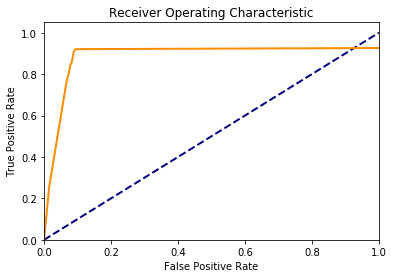

In [24]:
%matplotlib inline
# ROC Curve 를 출력한다
import matplotlib.pyplot as plt
lw = 2   # BaseLine을 그린다
plt.plot([0, 1], [0, 1], color='navy',  lw=lw, linestyle='--')
plt.plot(false_pos_rate, true_pos_rate, color = 'darkorange', lw = lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, pos_prob)

0.9629610085418291

<br/>

## **6 Sklearn 을 활용한 모델의 튜닟 및 교차검증**
1. 모델이 실질적으로 잘 작동하는지 **K-fold 검정을** 적용한다
1. **AUC 값의** 측정 : **ROC 커브의** 밑면적을 구한 값으로 **1에 가까울수록** 성능이 좋다.[참고](http://newsight.tistory.com/53)

<img src="https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg" align="left">

In [26]:
# 전체 10개의 폴드 생성기로 초기화 후 파라미터 분석을 진행합니다
from sklearn.model_selection import StratifiedKFold
k = 10
k_fold = StratifiedKFold(n_splits=k)

# 연산을 위해 Numpy 객체로 변환한다
cleaned_emails_np = np.array(cleaned_emails)
labels_np         = np.array(labels)

# 10 폴드 생성기 학습을 위한 파라미터를 정의합니다
max_features_option     = [2000, 4000, 8000]   # 가장 많이 사용되는 N개 단어를 선택
smoothing_factor_option = [0.5, 1.0, 1.5, 2.0] # Smoothing Parameter : 초기값
fit_prior_option        = [True, False]        # 사전 확률을 사용할지 여부

In [31]:
%%time
auc_record = {} # k_fold 분리된 객체를 활용하여 개별 환경에서 AUC를 측정
for train_indices, test_indices in k_fold.split(cleaned_emails, labels):
    X_train, X_test = cleaned_emails_np[train_indices], cleaned_emails_np[test_indices]
    Y_train, Y_test = labels_np[train_indices], labels_np[test_indices]

    # max_features_option 환경값을 바꿔가면서 AUC 테스트
    for max_features in max_features_option:        
        if max_features not in auc_record:
            auc_record[max_features] = {}
        cv = CountVectorizer(stop_words="english", max_features=max_features)
        term_docs_train = cv.fit_transform(X_train)
        term_docs_test  = cv.transform(X_test)
        
        # smoothing_factor_option 초기값을 바꾸며 AUC 테스트
        for smoothing_factor in smoothing_factor_option:
            if smoothing_factor not in auc_record[max_features]:
                auc_record[max_features][smoothing_factor] = {}
            
            # fit_prior_option : 사전확률을 바꾸며 AUC 테스트
            for fit_prior in fit_prior_option:
                clf = MultinomialNB(alpha=smoothing_factor, fit_prior=fit_prior)
                clf.fit(term_docs_train, Y_train)
                prediction_prob = clf.predict_proba(term_docs_test)
                pos_prob        = prediction_prob[:, 1]
                auc             = roc_auc_score(Y_test, pos_prob)
                auc_record[max_features][smoothing_factor][fit_prior] \
                    = auc + auc_record[max_features][smoothing_factor].get(fit_prior, 0.0)                

# 위에서 계산한 결과를 출력합니다
auc_result = []
for max_features, max_feature_record in auc_record.items():
    for smoothing, smoothing_record in max_feature_record.items():
        for fit_prior, auc in smoothing_record.items():
            auc_result.append([max_features, smoothing, fit_prior, auc/k])

CPU times: user 24.8 s, sys: 1.16 s, total: 26 s
Wall time: 26 s


In [32]:
import pandas as pd
auc_result = pd.DataFrame(auc_result)
auc_result.columns = ['max features', 'smoothing', 'fit prior', 'auc']
auc_result = auc_result.sort_values('auc', ascending=False).reset_index(drop=True)
auc_result.head()

max features  smoothing  fit prior       auc
0          8000        0.5       True  0.988589
1          8000        0.5      False  0.988520
2          8000        1.0       True  0.987575
3          8000        1.0      False  0.987436
4          8000        1.5       True  0.987039